In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

####Read in sample metadata

In [3]:
%%R
sample.md = read.table("data/Metadata_fungi.txt", 
                comment.char = "",
                header = TRUE,
                colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

####Read in OTU table

In [4]:
%%R
physeq = import_biom("data/otu_table_war_wtax.biom") 

####Add sample metadata to phyloseq object

In [5]:
%%R
sample_data(physeq) = sample.md
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1160 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1160 taxa by 10 taxonomic ranks ]


####Get heavy fractions from physeq object

In [6]:
%%R
dna.density.min = 1.7125
#rna.density.min = 1.825

md = sample_data(physeq)
criterion = md$Density >= with(md, dna.density.min)

physeq.heavy = prune_samples(criterion, physeq)

####Function for estimating fold change and standard error with DESeq2

In [7]:
%%R
get_l2fc = function(physeq.obj, Day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples(#physeq.md$RNA_DNA == RNA_DNA)&
                      (physeq.md$Day == Day), physeq.obj)
    dds = phyloseq_to_deseq2(p, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE")])
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

####Function arguments

In [8]:
%%R
m = expand.grid(Day = c(3, 7, 14, 30))
m

  Day
1   3
2   7
3  14
4  30


####mdply call with function arguments

In [9]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(m, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.heavy))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:

Source: local data frame [4,640 x 14]

     Day    OTU log2FoldChange     lfcSE  Rank1  Rank2      Rank3
   (dbl)  (chr)          (dbl)     (dbl) (fctr) (fctr)     (fctr)
1      3 OTU.33      0.2200029 0.5147938   Root  Fungi Zygomycota
2      3 OTU.57      0.1871753 1.7363765   Root  Fungi Ascomycota
3      3  OTU.2      1.2427068 0.3516070   Root  Fungi Ascomycota
4      3 OTU.40     -1.6628734 0.3508260   Root  Fungi Ascomycota
5      3  OTU.5     -0.1814598 0.5007064   Root  Fungi Ascomycota
6      3 OTU.80     -0.9462401 0.4268439   Root  Fungi Ascomycota
7      3  OTU.7      2.8379201 0.4067251   Root  Fungi Ascomycota
8      3  OTU.3     -0.2292293 0.3024772   Root  Fungi Ascomycota
9      3  OTU.4      1.6729646 0.5405250   Root  Fungi Ascomycota
10     3 OTU.10     -0.8701737 0.2785215   Root  Fungi Ascomycota
..   ...    ...            ...       ...    ...    ...        ...
Variables not shown: Rank4 (fctr), Rank5 (fctr), Rank6 (fctr), Rank7 (fctr),
  Rank8 (fctr), Rank9 (fct

#### Finding l2fc threshold as defined by 1 sd away from the mean l2fc for RNA/DNA combined

In [10]:
%%R
summarise(ungroup(df.l2fc),
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
      (dbl)
1 0.2676969


In [11]:
%%R
summarise(ungroup(df.l2fc),
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 2.207385


#### log2fold change threshold set at 2.5

####Now get sparsity info for each OTU

In [12]:
%%R
mdf.heavy = tbl_df(psmelt(physeq.heavy))

In [13]:
%%R
sparsity.df = mdf.heavy %>%
    group_by(OTU, Day, RNA_DNA) %>%
    summarize(sparsity = sum(Abundance > 0) / length(Abundance)) %>%
    #filter(Treatment == "13CCPS") %>%
    select(OTU, Day, RNA_DNA, sparsity)

sparsity.df

Source: local data frame [4,640 x 4]
Groups: OTU, Day [4640]

         OTU   Day RNA_DNA   sparsity
       (chr) (int)  (fctr)      (dbl)
1      OTU.1     3     DNA 1.00000000
2      OTU.1     7     DNA 1.00000000
3      OTU.1    14     DNA 1.00000000
4      OTU.1    30     DNA 1.00000000
5     OTU.10     3     DNA 1.00000000
6     OTU.10     7     DNA 1.00000000
7     OTU.10    14     DNA 1.00000000
8     OTU.10    30     DNA 1.00000000
9  OTU.10011     3     DNA 0.05263158
10 OTU.10011     7     DNA 0.00000000
..       ...   ...     ...        ...


####Add sparsity information to l2fc table

In [14]:
%%R
df.l2fc = left_join(df.l2fc, sparsity.df)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("Day", "OTU")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


####Add p-values to l2fc table

In [15]:
%%R
l2fc.threshold = 2.5
df.l2fc$p = with(df.l2fc, pnorm(log2FoldChange, l2fc.threshold, lfcSE, lower.tail = FALSE))

####Plot sparsity threshold versus number of adjusted p-values less than FDR

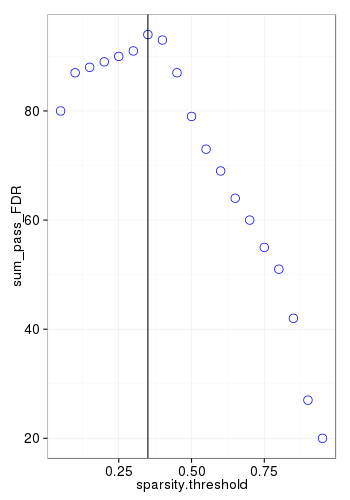

In [16]:
%%R -w 350 -h 500
FDR = 0.10

count_sig = function(df, sparsity.threshold) {
    d = df %>%
            filter(sparsity >= sparsity.threshold) %>%
            mutate(padj = p.adjust(p, method = "BH"))%>% 
            summarize(sum_pass_FDR = sum(padj <= FDR))
    d
}

thresh = seq(0.05, 0.95, 0.05)
names(thresh) = thresh

d.sparsity = ldply(thresh, count_sig, .id = "sparsity.threshold", df = df.l2fc)
d.sparsity$sparsity.threshold = as.numeric(as.character(d.sparsity$sparsity.threshold))

p = ggplot(d.sparsity, aes(x = sparsity.threshold, y = sum_pass_FDR))

#p = p + facet_wrap(~RNA_DNA, ncol = 1, scales = "free_y")

p = p + geom_point(size = 4, shape = 21, color = "blue")

p = p + geom_vline(x = 0.35)

p = p + theme_bw()
    
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 14),
              strip.text = element_text(size = 14),
              strip.background = element_blank())

p

####Remove OTU/Day/RNA_DNA rows below sparsity threshold and add adjusted p-value to l2fc table 

In [17]:
%%R
sparsity.threshold = 0.35
df.l2fc = df.l2fc %>% 
    filter(sparsity >= sparsity.threshold) %>%
    mutate(padj = p.adjust(p, method = "BH"))
df.l2fc

Source: local data frame [1,066 x 18]

     Day    OTU log2FoldChange     lfcSE  Rank1  Rank2      Rank3
   (dbl)  (chr)          (dbl)     (dbl) (fctr) (fctr)     (fctr)
1      3 OTU.33      0.2200029 0.5147938   Root  Fungi Zygomycota
2      3  OTU.2      1.2427068 0.3516070   Root  Fungi Ascomycota
3      3 OTU.40     -1.6628734 0.3508260   Root  Fungi Ascomycota
4      3  OTU.5     -0.1814598 0.5007064   Root  Fungi Ascomycota
5      3 OTU.80     -0.9462401 0.4268439   Root  Fungi Ascomycota
6      3  OTU.7      2.8379201 0.4067251   Root  Fungi Ascomycota
7      3  OTU.3     -0.2292293 0.3024772   Root  Fungi Ascomycota
8      3  OTU.4      1.6729646 0.5405250   Root  Fungi Ascomycota
9      3 OTU.10     -0.8701737 0.2785215   Root  Fungi Ascomycota
10     3 OTU.16      0.5731812 0.2262407   Root  Fungi Ascomycota
..   ...    ...            ...       ...    ...    ...        ...
Variables not shown: Rank4 (fctr), Rank5 (fctr), Rank6 (fctr), Rank7 (fctr),
  Rank8 (fctr), Rank9 (fct

In [18]:
%%R
write.table(df.l2fc, "data/l2fc_warcup.csv", row.names = FALSE, sep = ",")
df.l2fc

Source: local data frame [1,066 x 18]

     Day    OTU log2FoldChange     lfcSE  Rank1  Rank2      Rank3
   (dbl)  (chr)          (dbl)     (dbl) (fctr) (fctr)     (fctr)
1      3 OTU.33      0.2200029 0.5147938   Root  Fungi Zygomycota
2      3  OTU.2      1.2427068 0.3516070   Root  Fungi Ascomycota
3      3 OTU.40     -1.6628734 0.3508260   Root  Fungi Ascomycota
4      3  OTU.5     -0.1814598 0.5007064   Root  Fungi Ascomycota
5      3 OTU.80     -0.9462401 0.4268439   Root  Fungi Ascomycota
6      3  OTU.7      2.8379201 0.4067251   Root  Fungi Ascomycota
7      3  OTU.3     -0.2292293 0.3024772   Root  Fungi Ascomycota
8      3  OTU.4      1.6729646 0.5405250   Root  Fungi Ascomycota
9      3 OTU.10     -0.8701737 0.2785215   Root  Fungi Ascomycota
10     3 OTU.16      0.5731812 0.2262407   Root  Fungi Ascomycota
..   ...    ...            ...       ...    ...    ...        ...
Variables not shown: Rank4 (fctr), Rank5 (fctr), Rank6 (fctr), Rank7 (fctr),
  Rank8 (fctr), Rank9 (fct

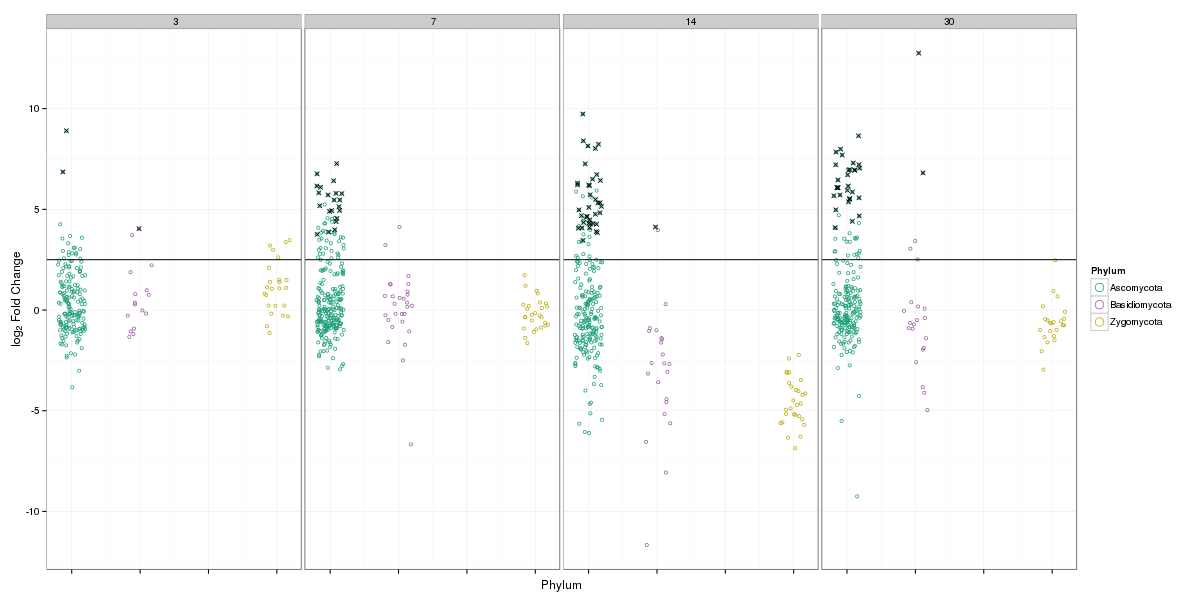

In [19]:
%%R -w 1200 -h 600
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank3)
d$Rank2[is.na(d$Rank3)] = "unclassified"
d$Rank2 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [20]:
%%R

#OTUS that are responders by day
Day3 = filter(df.l2fc, Day == 3, padj <=0.10)
Day7 = filter(df.l2fc, Day == 7, padj <=0.10)
Day14 = filter(df.l2fc, Day == 14, padj <=0.10)
Day30 = filter(df.l2fc, Day == 30, padj <=0.10)

print(length(Day3$OTU))
print(length(Day7$OTU))
print(length(Day14$OTU))
print(length(Day30$OTU))


[1] 3
[1] 21
[1] 38
[1] 32


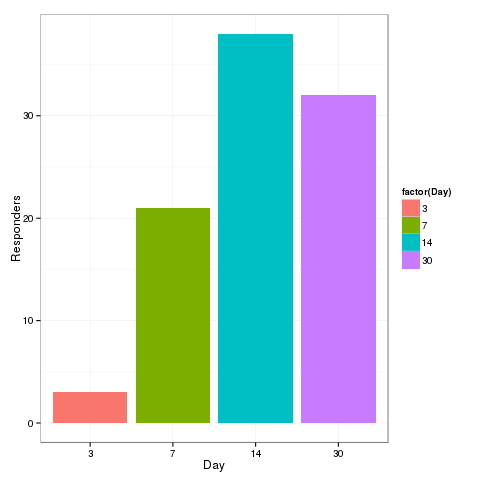

In [21]:
%%R
d = df.l2fc %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = factor(Day), y = responders, fill = factor(Day)))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + theme_bw()

px = px + xlab("Day") + ylab("Responders")


px

In [22]:
%%R
ggsave(filename = "data/figs/l2fc_histogram", plot = px, width = 12, height = 7)


Error in get(as.character(FUN), mode = "function", envir = envir) : 
  object 'data/figs/l2fc_histogram' of mode 'function' was not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in get(as.character(FUN), mode = "function", envir = envir) : 
  object 'data/figs/l2fc_histogram' of mode 'function' was not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning message:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In brewer.pal(10, "Dark2") :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/

In [23]:
%%R
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank5) 

In [24]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder/unknown"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "Responder"

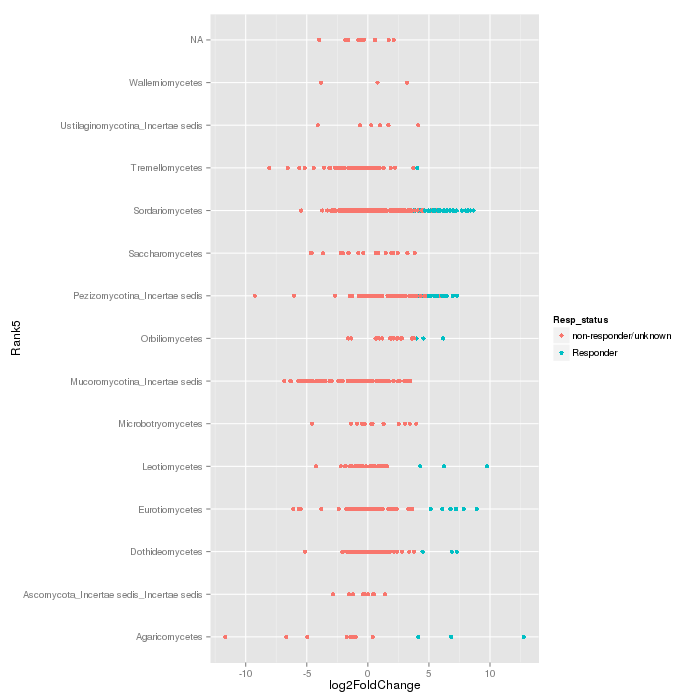

In [25]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank5))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

## Blasting against Living Tree Project db

In [26]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [27]:
from cogent import LoadSeqs, DNA


In [28]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

>OTU.162
TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCTGTGAAATCTGGGGGCTCAACCCCCAGCCTGCAGTGGGTACGGGCAGACTAGAGTGCGGTAGGGGAGATTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGATCTCTGGGCCGTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCATGCCGTAAACGTTGGGAACTAGATGTGGGGACCATTCCACGGTCTCCGTGTCGCAGCTAACGCATTAAGTTCCCCGCCTGGGGAGTACGGCCGCAAGGCTA
>OTU.239
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCAGAGCTCAACTCTGGAATAGCCTTTAAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGATAACTAGCTGTCTGGGTGCTTGGCACTTAGGTGGCGCAGCTAACGCATTAAGTTATCCGCCTGGGGAGTACGGTCGCAAGATTA
>OTU.2456
TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCATATAAGTCAGTGGTGAAATCCCCGAGCTTAACTTGGGAACTGCCATTGATACTATGTGTCTTGAATATCGCGGAGGTAAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCGATTGCGAAGGCAGCTTACTACACGATCATTGACG

In [29]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [30]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

blastn -out otusn_silvaRefNR115.m6 -outfmt 6 -query seqs.fasta -db /var/seq_data/silva/silva_blastdb/silva_RefNR_115 -num_threads 5


('', '')

In [31]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

OTU.162	HQ256829	100.00	375	0	0	1	375	445	819	0.0	  693
3000 otusn_silvaRefNR115.m6
500


In [32]:
from IPython.display import Image
import pandas.rpy.common as com

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


In [33]:
%%R
library(data.table)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: data.table 1.9.4  For help type: ?data.table

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: *** NB: by=.EACHI is now explicit. See README to restore previous behaviour.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘data.table’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:dplyr’:

    between, last


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [34]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))


Error in eval(expr, envir, enclos) : 
  error in evaluating the argument 'x' in selecting a method for function 'rank': Error in (function (classes, fdef, mtable)  : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : 
  error in evaluating the argument 'x' in selecting a method for function 'rank': Error in (function (classes, fdef, mtable)  : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [35]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)


Error in head(top_hits_df_LTP) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': Error: object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(top_hits_df_LTP) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': Error: object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [36]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [37]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)


Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In `names<-.data.table`(`*tmp*`, value = value) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  The colnames(x)<-value syntax copies the whole table. This is due to <- in R itself. Please change to setnames(x,old,new) which does not copy and is faster. See help('setnames'). You can safely ignore this warning if it is inconvenient to change right now. Setting options(warn=2) turns this warning into an error, so you can then use traceback() to find and change your colnames<- calls.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [38]:
%%R
joined_df = filter(joined_df, name != "NA")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [39]:
%%R
dim(joined_df)


Error in withVisible({ : object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [40]:
df = com.load_data("joined_df")

LookupError: 'joined_df' not found

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")